# CrowdTruth metrics 2.0 documentation

Let:

* $workers(u):$ all workers that annotate media unit $u$;
* $units(i):$ all input media units annotated by worker $i$;
* $WorkVec(i, u):$ annotations of worker $i$ on media unit $u$ as a binary vector;
* $MediaUnitVec(s) = \sum_{i \in workers(s)} WorkVec(i,s)$, where $s$ is an input media unit.

## Media Unit Quality Score (UQS)

The unit quality score $UQS(u)$ is computed as the average cosine similarity between all worker vectors for a given input media unit $u$, weighted by the worker quality ($WQS$) and annotation quality ($AQS$). The goal is to capture the degree of agreement in annotating the media unit. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score.

$$ UQS(u) = \frac{\sum_{i, j \in workers(u)} Wcos(WorkVec(i,u), WorkVec(j,u)) \; WQS(i) \; WQS(j)}{\sum_{i, j \in workers(u)} WQS(i) \; WQS(j)}, \; i \neq j.$$


### Weighted Cosine

To weigh the metrics with the annotation quality, we compute $Wcos$, the weighted version of the cosine similarity. This metric is only applicable to closed tasks, where annotation quality can be calculated across media units. For open-ended tasks, we consider annotation quality equal to 1 and calculate the regular cosine similarity.

$$ Wcos(vec_1, vec_2) = \frac{\sum_{a} vec_1(a) \; vec_2(a) \; AQS(a)}{\sqrt{(\sum_{a} vec_1^2(a) \; AQS(a)) \; (\sum_{a} vec_2^2(a) \; AQS(a))}} .$$ 


## Worker Quality Score (WQS)

The worker quality score $WQS(i)$ for a given worker $i$ is the product of 2 separate metrics - the worker-worker agreement $WWA(i)$ and the worker-media unit agreement $WUA(i)$.

$$ WQS(i) = WUA(i) \; WWA(i) .$$

### Worker-Media Unit Agreement

The worker-media unit agreement $WUA(i)$ is the average cosine distance between the annotations of a worker $i$ and all annotations for the media units they have worked on, weighted by the media unit and annotation quality. It calculates how much a worker disagrees with the crowd on a media unit basis. Through the weighted average, media units and anntation with lower quality will have less of an impact on the final score.

$$ WSA(i) = \frac{\sum_{u \in units(i)} Wcos(WorkVec(i,u), MediaUnitVec(u) - WorkVec(i, u)) \; UQS(u)}{\sum_{u \in units(i)} UQS(u)} .$$

### Worker-Worker Agreement

The worker-worker agreement $WWA(i)$ is the average cosine distance between the annotations of a worker $i$ and all other workers that have worked on the same media units as worker $i$, weighted by the worker and annotation qualities. The metric gives an indication as to whether there are consisently like-minded workers. This is useful for identifying communities of thought. Through the weighted average, workers and annotations with lower quality will have less of an impact on the final score of the given worker.

$$ WWA(i) = \frac{ \sum_{j \in workers(u \in units(i))} Wcos(WorkVec(i, u), WorkVec(j, u)) \; WQS(j) \; UQS(u) }{ \sum_{j \in workers(s \in units(i))} WQS(j) \; UQS(u) }, \; i \neq j .$$


## Annotation Quality Score (AQS)

The annotation quality score $AQS(a)$ calculates the agreement of selecting an annotation $a$, over all the media units it appears in. Therefore, it is only applicable to closed tasks, where the same annotation set is used for all input media units. It is based on $P_a(i | j)$, the probability that if a worker $j$ annotates $a$ in a media unit, worker $i$ will also annotate it. 

$$ P_a(i | j) = \frac{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(i, s)(r) \; WorkVec(j, s)(r) }{ \sum_{u \in units(i) \cap units(j) } UQS(u) \; WorkVec(j, u)(r) } . $$

$AQS(a)$ is the weighted average of $P_a(i | j)$ for all possible pairs of workers. Through the weighted average, input media units and workers with lower quality will have less of an impact on the final score of the annotation.

$$ AQS(a) = \frac{ \sum_{i,j} WQS(i) \; WQS(j) \; P_a(i | j) }{ \sum_{i,j} WQS(i) \; WQS(j) }, i \neq j . $$


## Media Unit-Annotation Score (UAS)

The media unit - annotation score $UAS(u, a)$ calculates the likelihood that annotation $a$ is expressed in input media unit $u$. It is the ratio of the number of workers that picked annotation $u$ over all workers that annotated the unit, weighted by the worker quality.

$$ UAS(u, a) = \frac{ \sum_{i \in workers(u)} WorkVec(i,u)(a) \; WQS(i) }{ \sum_{i \in workers(u)} WQS(i) }. $$

# Run the metrics

In [1]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

class config(DefaultConfig):
    inputColumns = ["index", "number", "events1", "sentence1", "sentence1_id", "pair1", "pair2", "pair3", "pair4", "pair5", "pair6", "pair7", "pair8", "pair9", "pair10", "pair11", "pair12", "pair13", "pair14", "pair15", "pair16", "pair17", "pair18", "pair19", "pair20", "pair21", "pair22", "pair23", "pair24", "pair25", "pair26", "pair27", "pair28", "pair29", "pair30"]
    outputColumns = ["relations"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = [
    ]
    
    column_separator = ","
    vector_separator = "\n"
        
    def processJudgments(self, judgments):
        # change default separator to whitespace to make it work with our file
        for col in self.outputColumns:
            judgments[col] = judgments[col].apply(lambda x: x.replace('\n', ','))
        return judgments

Creating a class that inherits from `Configuration` lets us define how the input file will be processed:

* `inputColumns`: list of input columns from the .csv file, the input that the workers were shown
* `outputColumns`: list of output columns with the answers from the workers
* `processJudgments`: function that defines how the worker judgments wil be processed; default separator for judgments is ','

To build the annotation vector, we also need to specify whether this is an **open-ended** or **closed** task, using the `open_ended_task` variable.

* **open-ended task** means that the annotation space is not known, and workers can freely provide all the choices that apply (e.g. in sound tagging, the workers are provided with a text box to enter all tags they can think of)
* **closed task** means that the annotations that can occur in the data are already known, and the workers are asked to validate their existence (e.g. for medical relation extraction, the workers pick from a pre-defined multiple-choice set of relations)

If the task we are processing is **closed**, then we also need to provide the list of possible annotations in the `annotation_vector` variable.

In [2]:
# Read data
data, config = crowdtruth.load(
    directory = "../data/input/pilot",
    config = config()
)

data['judgments'].head()

INFO:root:Config loaded
INFO:root:Found 5 files
INFO:root:Processing f1009969.csv
INFO:root:Values not stored as dictionary
INFO:root:Processing f1009968.csv
INFO:root:Values not stored as dictionary
INFO:root:Processing f1009971.csv
INFO:root:Values not stored as dictionary
INFO:root:Processing f1009972.csv
INFO:root:Values not stored as dictionary
INFO:root:Processing f1009967.csv
INFO:root:Values not stored as dictionary


,output.relations,submitted,started,worker,unit,duration,job
judgment,,,,,,,
2529822390,"{u'Strong_27_33--panic_74_79': 1, u'Strong_27_...",2017-05-02 12:26:07,2017-05-02 12:25:32,38202325,1220654005,35,../data/input/pilot/f1009969
2529878633,{u'Poured_47_53-r-earthquake_5_15': 1},2017-05-02 13:20:59,2017-05-02 13:20:47,24835873,1220654005,12,../data/input/pilot/f1009969
2529921609,"{u'Strong_27_33-r-earthquake_5_15': 1, u'Poure...",2017-05-02 13:51:35,2017-05-02 13:51:00,39073124,1220654005,35,../data/input/pilot/f1009969
2529922788,"{u'Strong_27_33--panic_74_79': 1, u'Strong_27_...",2017-05-02 13:52:32,2017-05-02 13:51:48,6352345,1220654005,44,../data/input/pilot/f1009969
2529927591,"{u'Poured_47_53-r-earthquake_5_15': 1, u'Panic...",2017-05-02 13:56:20,2017-05-02 13:55:09,37153540,1220654005,71,../data/input/pilot/f1009969


In [3]:
results = crowdtruth.run(data, config)

INFO:root:Using experimental version a2
INFO:root:1 iterations; max d= 1.0 ; wqs d= 0.67504457983; sqs d= 0.552941791941; rqs d= 0.0
INFO:root:2 iterations; max d= 0.262762441663 ; wqs d= 0.108559735961; sqs d= 0.0832577710545; rqs d= 0.0
INFO:root:3 iterations; max d= 0.057355593351 ; wqs d= 0.0134081576698; sqs d= 0.00998589285655; rqs d= 0.0
INFO:root:4 iterations; max d= 0.0253162507506 ; wqs d= 0.00448643976441; sqs d= 0.00441797427184; rqs d= 0.0
INFO:root:5 iterations; max d= 0.00768233912241 ; wqs d= 0.00110369047729; sqs d= 0.000770507184896; rqs d= 0.0
INFO:root:6 iterations; max d= 0.00369812948961 ; wqs d= 0.000376462215782; sqs d= 0.00031783317636; rqs d= 0.0
INFO:root:7 iterations; max d= 0.00102449209367 ; wqs d= 9.90111413079e-05; sqs d= 7.16595092186e-05; rqs d= 0.0
INFO:root:8 iterations; max d= 0.000525765030186 ; wqs d= 3.7731067765e-05; sqs d= 2.75859892325e-05; rqs d= 0.0


### Plot the unit quality score (UQS) at the beginning of the process and at the end

Text(0,0.5,u'# Units')

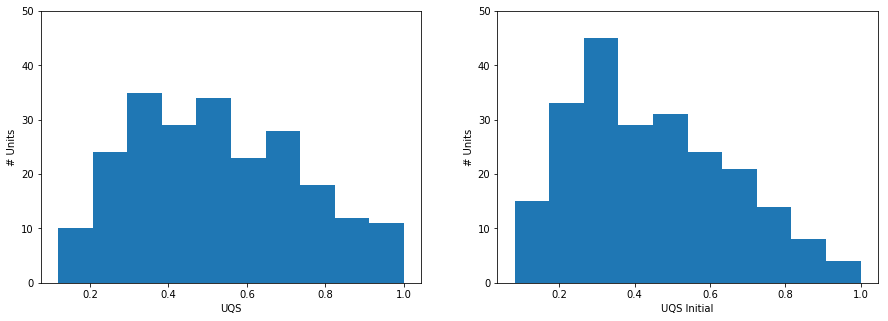

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results["units"]["uqs"], normed=False)
plt.ylim(0, 50)
plt.xlabel("UQS")
plt.ylabel("# Units")

plt.subplot(1, 2, 2)
plt.hist(results["units"]["uqs_initial"], normed=False)
plt.ylim(0, 50)
plt.xlabel("UQS Initial")
plt.ylabel("# Units")

### Plot the change in unit qualtity score at the beginning of the process and at the end

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,0,u'Unit Index')

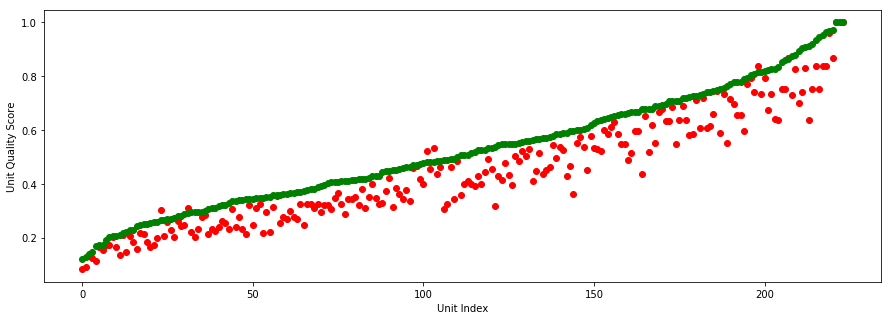

In [5]:
import numpy as np

sortUQS = results["units"].sort(['uqs'], ascending=[1])
sortUQS = sortUQS.reset_index()

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortUQS.shape[0]), sortUQS["uqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Unit Quality Score')
plt.xlabel('Unit Index')

### Plot the worker quality score (UQS) at the beginning of the process and at the end

In [6]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wqs_initial
worker,,,,,,
1855113,8.833333,2,4,4,0.361471,0.188955
4316379,44.158333,3,19,19,0.441424,0.245790
4338784,53.666667,1,15,15,0.571542,0.451965
5626024,61.666667,1,3,3,0.063832,0.046246
6082058,81.285714,1,7,7,0.290365,0.226281


Text(0,0.5,u'# Workers')

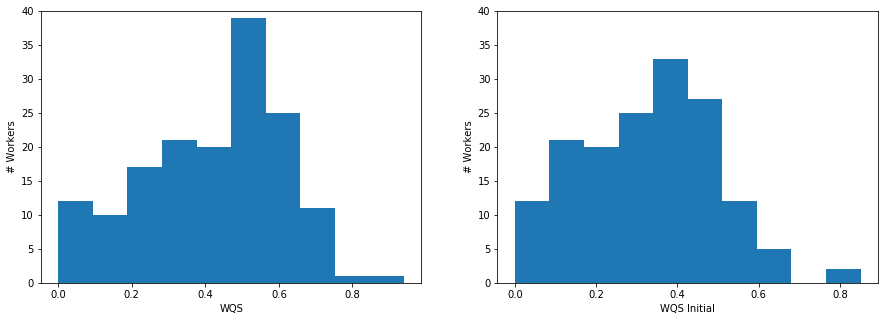

In [7]:
plt.rcParams['figure.figsize'] = 15, 5

plt.subplot(1, 2, 1)
plt.hist(results["workers"]["wqs"])
plt.ylim(0, 40)
plt.xlabel("WQS")
plt.ylabel("# Workers")

plt.subplot(1, 2, 2)
plt.hist(results["workers"]["wqs_initial"])
plt.ylim(0, 40)
plt.xlabel("WQS Initial")
plt.ylabel("# Workers")

### Plot the change in worker qualtity score at the beginning of the process and at the end

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


Text(0.5,0,u'Worker Index')

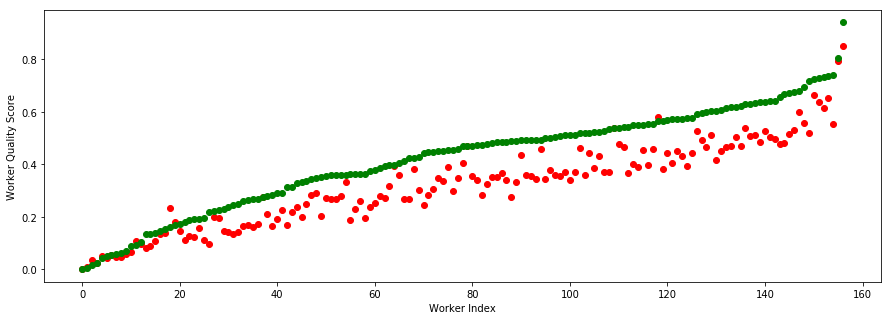

In [8]:
sortWQS = results["workers"].sort(['wqs'], ascending=[1])
sortWQS = sortWQS.reset_index()

plt.rcParams['figure.figsize'] = 15, 5

plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs_initial"], 'ro', lw = 1, label = "Initial UQS")
plt.plot(np.arange(sortWQS.shape[0]), sortWQS["wqs"], 'go', lw = 1, label = "Final UQS")

plt.ylabel('Worker Quality Score')
plt.xlabel('Worker Index')

## Save results

In [9]:
sortWQS.to_csv("../data/results/pilot_workers.csv", index=False)

In [10]:
rows = []
header = list(sortUQS)
header.extend(["event-event_pair", "no_of_annotations", "event-event_pair_final_score", "event-event_pair_initial_score"])

rows.append(header)

for i in range(len(sortUQS.index)):
    keys = []
    if (str(sortUQS["input.pair1"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair1"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair1"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair2"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair2"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair2"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair3"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair3"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair3"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair4"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair4"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair4"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair5"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair5"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair5"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair6"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair6"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair6"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair7"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair7"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair7"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair8"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair8"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair8"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair9"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair9"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair9"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair10"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair10"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair10"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair11"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair11"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair11"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair12"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair12"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair12"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair13"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair13"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair13"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair14"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair14"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair14"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair15"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair15"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair15"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair16"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair16"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair16"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair17"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair17"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair17"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair18"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair18"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair18"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair19"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair19"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair19"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair20"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair20"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair20"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair21"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair21"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair21"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair22"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair22"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair22"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair23"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair23"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair23"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair24"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair24"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair24"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair25"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair25"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair25"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair26"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair26"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair26"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair27"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair27"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair27"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair28"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair28"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair28"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair29"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair29"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair29"].iloc[i]).replace(', ', '-r-'))
    if (str(sortUQS["input.pair30"].iloc[i]) != "nan"):
        keys.append(str(sortUQS["input.pair30"].iloc[i]).replace(', ', '--'))
        keys.append(str(sortUQS["input.pair30"].iloc[i]).replace(', ', '-r-'))
    keys.append("no_relation")
    
    for j in range(len(keys)):
        row = list(sortUQS.iloc[i])
        row.append(keys[j])
        #if (keys[j] not in sortUQS["output.relations"].iloc[i]):
        #    print(keys[j])
        row.append(sortUQS["output.relations"].iloc[i][keys[j]])
        row.append(sortUQS["unit_annotation_score"].iloc[i][keys[j]])
        row.append(sortUQS["unit_annotation_score_initial"].iloc[i][keys[j]])
    
        rows.append(row)
        
        
import csv

with open('../data/results/pilot_results.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(rows)

## Evaluate the crowd against the experts

In [11]:
import pandas as pd
import numpy as np

crowd = pd.read_csv('../data/results/pilot_results.csv')
crowd["Experts"] = pd.Series(np.random.randn(len(crowd.index)), index=crowd.index)

experts = pd.read_csv('../data/ground_truth/pilot_experiments_ground_truth.csv')

for i in range(len(crowd.index)):
    crowd["Experts"].iloc[i] = 0
    
for i in range(len(crowd.index)):
    if (crowd["event-event_pair"].iloc[i] != "no_relation"):    
        if '-r-' in str(crowd["event-event_pair"].iloc[i]) :
            allPairs_comp = crowd["event-event_pair"].iloc[i].split("-r-")
            offsets1 = allPairs_comp[0].split("_")
            offsets2 = allPairs_comp[1].split("_")
            offsets1_set = (offsets1[-1], offsets1[-2])
            offsets2_set = (offsets2[-1], offsets2[-2])
                
            for j in range(len(experts.index)):
                if experts["Document Id"].iloc[j] == crowd["input.sentence1_id"].iloc[i]:
                    if '-r-' in str(experts["Event-Event Pair"].iloc[j]) :
                        expertPairs_comp = experts["Event-Event Pair"].iloc[j].split("-r-")
                        offsets1_exp = expertPairs_comp[0].split("_")
                        offsets2_exp = expertPairs_comp[1].split("_")
                        offsets1_set_exp = (offsets1_exp[-1], offsets1_exp[-2])
                        offsets2_set_exp = (offsets2_exp[-1], offsets2_exp[-2])
            
                        if offsets1_set == offsets1_set_exp and offsets2_set == offsets2_set_exp :
                            crowd["Experts"].iloc[i] = 1
                    else:
                        expertPairs_comp = experts["Event-Event Pair"].iloc[j].split("--")
                        offsets1_exp = expertPairs_comp[0].split("_")
                        offsets2_exp = expertPairs_comp[1].split("_")
                        offsets1_set_exp = (offsets1_exp[-1], offsets1_exp[-2])
                        offsets2_set_exp = (offsets2_exp[-1], offsets2_exp[-2])
            
                        if offsets1_set == offsets2_set_exp and offsets2_set == offsets1_set_exp :
                            crowd["Experts"].iloc[i] = 1
        else:
            allPairs_comp = crowd["event-event_pair"].iloc[i].split("--")
            offsets1 = allPairs_comp[0].split("_")
            offsets2 = allPairs_comp[1].split("_")
            offsets1_set = (offsets1[-1], offsets1[-2])
            offsets2_set = (offsets2[-1], offsets2[-2])
                
            for j in range(len(experts.index)):
                if experts["Document Id"].iloc[j] == crowd["input.sentence1_id"].iloc[i]:
                    if '--' in str(experts["Event-Event Pair"].iloc[j]) :
                        expertPairs_comp = experts["Event-Event Pair"].iloc[j].split("--")
                        offsets1_exp = expertPairs_comp[0].split("_")
                        offsets2_exp = expertPairs_comp[1].split("_")
                        offsets1_set_exp = (offsets1_exp[-1], offsets1_exp[-2])
                        offsets2_set_exp = (offsets2_exp[-1], offsets2_exp[-2])
            
                        if offsets1_set == offsets1_set_exp and offsets2_set == offsets2_set_exp :
                            crowd["Experts"].iloc[i] = 1

                    else:
                        expertPairs_comp = experts["Event-Event Pair"].iloc[j].split("-r-")
                        offsets1_exp = expertPairs_comp[0].split("_")
                        offsets2_exp = expertPairs_comp[1].split("_")
                        offsets1_set_exp = (offsets1_exp[-1], offsets1_exp[-2])
                        offsets2_set_exp = (offsets2_exp[-1], offsets2_exp[-2])
            
                        if offsets1_set == offsets2_set_exp and offsets2_set == offsets1_set_exp :
                            crowd["Experts"].iloc[i] = 1
            
crowd.to_csv('../data/results/pilot_results.csv', index=False)

/Users/oanainel/anaconda/envs/CrowdTruth2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
import pandas as pd
import sys
sys.path.append('../scripts')

import eval_crowd_results as eval_script

crowd = pd.read_csv('../data/results/pilot_results.csv')
eval_file = eval_script.compute_crowd_performance(crowd, "../data/results/out_pilot/", "event-event_pair_final_score")
     
with open('../data/results/eval_pilot_pair_directionality.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(eval_file)

In [24]:
eval_pilot = pd.read_csv('../data/results/eval_pilot_pair_directionality.csv')
eval_pilot

,Thresh,TP,TN,FP,FN,Precision,Recall,Accuracy,F1-score
0,0.05,346,1130,1462,16,0.191372,0.955801,0.499661,0.318894
1,0.10,331,1659,933,31,0.261867,0.914365,0.673663,0.407134
2,0.15,324,1842,750,38,0.301676,0.895028,0.733243,0.451253
3,0.20,316,2000,592,46,0.348018,0.872928,0.784022,0.497638
4,0.25,308,2098,494,54,0.384040,0.850829,0.814489,0.529210
5,0.30,290,2178,414,72,0.411932,0.801105,0.835477,0.544090
6,0.35,286,2240,352,76,0.448276,0.790055,0.855112,0.572000
7,0.40,272,2309,283,90,0.490090,0.751381,0.873731,0.593239
8,0.45,253,2358,234,109,0.519507,0.698895,0.883886,0.595995
9,0.50,239,2397,195,123,0.550691,0.660221,0.892349,0.600503


## Evaluate the crowd at the level of event pairs, without directionality

In [18]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("../data/results/pilot_results.csv")

dataset = dataset[dataset["event-event_pair"] != "no_relation"]
header = list(dataset)
header.extend(["event-event_pair_only", "event-event_pair_only_final_score", "event-event_pair_only_initial_score"])
only_pair_dataset = []
only_pair_dataset.append(header)

for i in range(0, len(dataset.index), 2):
    row = list(dataset.iloc[i])
    row.append(dataset["event-event_pair"].iloc[i])
    if (dataset["event-event_pair_final_score"].iloc[i] >= dataset["event-event_pair_final_score"].iloc[i+1]):
        row.append(dataset["event-event_pair_final_score"].iloc[i])
        row.append(dataset["event-event_pair_initial_score"].iloc[i])
    else: 
        row.append(dataset["event-event_pair_final_score"].iloc[i+1])
        row.append(dataset["event-event_pair_initial_score"].iloc[i+1])
    
    only_pair_dataset.append(row)

import csv
with open('../data/results/pilot_results_only_pairs.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(only_pair_dataset)

In [20]:
crowd_results = pd.read_csv('../data/results/pilot_results_only_pairs.csv')
crowd_results["Experts_Pair"] = pd.Series(np.random.randn(len(crowd_results.index)), index=crowd_results.index)

experts = pd.read_csv('../data/ground_truth/pilot_experiments_ground_truth.csv')
 
for i in range(len(crowd_results.index)):
    crowd_results["Experts_Pair"].iloc[i] = 0

for i in range(len(crowd_results.index)):
    allPairs_comp = crowd_results["event-event_pair"].iloc[i].split("--")
    offsets1 = allPairs_comp[0].split("_")
    offsets2 = allPairs_comp[1].split("_")
    offsets1_set = (offsets1[-1], offsets1[-2])
    offsets2_set = (offsets2[-1], offsets2[-2])
    for j in range(len(experts.index)):
        if experts["Document Id"].iloc[j] == crowd_results["input.sentence1_id"].iloc[i]:
            if '--' in str(experts["Event-Event Pair"].iloc[j]) :
                expertPairs_comp = experts["Event-Event Pair"].iloc[j].split("--")
                offsets1_exp = expertPairs_comp[0].split("_")
                offsets2_exp = expertPairs_comp[1].split("_")
                offsets1_set_exp = (offsets1_exp[-1], offsets1_exp[-2])
                offsets2_set_exp = (offsets2_exp[-1], offsets2_exp[-2])
            
                if offsets1_set == offsets1_set_exp and offsets2_set == offsets2_set_exp :
                    crowd_results["Experts_Pair"].iloc[i] = 1
                elif offsets1_set == offsets2_set_exp and offsets2_set == offsets1_set_exp:
                    crowd_results["Experts_Pair"].iloc[i] = 1
                   
            else:
                expertPairs_comp = experts["Event-Event Pair"].iloc[j].split("-r-")
                offsets1_exp = expertPairs_comp[0].split("_")
                offsets2_exp = expertPairs_comp[1].split("_")
                offsets1_set_exp = (offsets1_exp[-1], offsets1_exp[-2])
                offsets2_set_exp = (offsets2_exp[-1], offsets2_exp[-2])
               
                if offsets1_set == offsets2_set_exp and offsets2_set == offsets1_set_exp :
                    crowd_results["Experts_Pair"].iloc[i] = 1
                elif offsets2_set == offsets2_set_exp and offsets1_set == offsets1_set_exp :
                    crowd_results["Experts_Pair"].iloc[i] = 1
            
crowd_results.to_csv('../data/results/pilot_results_only_pairs.csv', index=False)

In [25]:
import pandas as pd
import sys
sys.path.append('../scripts')

import eval_crowd_results as eval_script
reload(eval_script)

crowd = pd.read_csv('../data/results/pilot_results_only_pairs.csv')
eval_file = eval_script.compute_crowd_performance_pair_only(crowd, "../data/results/out_pilot/", "event-event_pair_only_final_score")
     
with open('../data/results/eval_pilot_pair_only.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(eval_file)

In [26]:
eval_pilot = pd.read_csv('../data/results/eval_pilot_pair_only.csv')
eval_pilot

,Thresh,TP,TN,FP,FN,Precision,Recall,Accuracy,F1-score
0,0.05,358,188,927,4,0.278599,0.988950,0.369668,0.434730
1,0.10,344,361,754,18,0.313297,0.950276,0.477319,0.471233
2,0.15,337,461,654,25,0.340061,0.930939,0.540284,0.498152
3,0.20,329,573,542,33,0.377727,0.908840,0.610697,0.533658
4,0.25,319,655,460,43,0.409499,0.881215,0.659445,0.559159
5,0.30,302,726,389,60,0.437048,0.834254,0.696005,0.573599
6,0.35,297,781,334,65,0.470681,0.820442,0.729858,0.598187
7,0.40,282,845,270,80,0.510870,0.779006,0.763033,0.617068
8,0.45,261,889,226,101,0.535934,0.720994,0.778605,0.614841
9,0.50,247,928,187,115,0.569124,0.682320,0.795531,0.620603
